# English Premier League VAR Analysis
## Part 3 - Analysis of Teams' VAR Incident Statistics
___

**Questions**
- Do the big 6 teams have more decisions in (or against) their favour? **[DONE]**
- Which team is involved in the most VAR incidents? Which team had the most FOR decisions, and which team had the most AGAINST decisions **[DONE]**
- What is the impact of VAR for decisions on the team's final league position and points tally? **[DONE]**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import difflib
import seaborn as sns

from collections import Counter
from datetime import datetime as dt
from scipy.stats import ttest_ind

pd.options.display.max_rows = 500

### Data Processing

In [2]:
file_date = '20210513'

In [3]:
# Import team stats dataset
teamstats_df = pd.read_csv(f'data/EPL_VAR_Team_Stats_Raw_{file_date}.csv')

In [4]:
# NOT using this method because of misspellings in incidents column (from original data). To use
# VAR decisions tally directly from the website

# # Add column of decisions FOR and decisions AGAINST (from incidents data)
# incidents_df_raw = pd.read_csv('data/EPL_VAR_Incidents_Processed_20210510.csv')

# incidents_df_1 = incidents_df_raw[['team', 'year', 'team_decision', 'incident']]
# incidents_df_2 = incidents_df_raw[['opposition', 'year', 'opposition_decision', 'incident']]

# incidents_df_2.columns = incidents_df_1.columns
# incidents_df = pd.concat([incidents_df_1, incidents_df_2])
# incidents_df.reset_index(drop=True, inplace=True)
# incidents_df

# # Create pivot table and reset index
# decision_count = incidents_df.pivot_table(index=['team', 'year'], columns='team_decision', aggfunc='size', fill_value=0)
# decision_count = decision_count.rename_axis(None, axis=1).reset_index(drop=False)
# decision_count.columns = ['team_name', 'year', 'decisions_against', 
#                           'decisions_for', 'decisions_neutral']

# Clean up decisions and incidents columns
# for i, row in incidents_df.iterrows():
#     if row['team_decision'] not in ['For', 'Against', 'Neutral']:
#         incidents_df.loc[i, 'team_decision'] = 'Neutral'
        
#     text = row['incident']
#     text_clean = text.split(" - ")[0]  # Remove the - FOR and - AGAINST strings
#     incidents_df.loc[i, 'incident'] = text_clean

In [5]:
# Create helper function to rename team names so that they can be merged
def rename_team_names(df, col_name):  
    for i, row in df.iterrows():
        if row[col_name] == 'Brighton':
            df.loc[i, col_name] = 'Brighton & Hove Albion'
        if row[col_name] == 'Leicester':
            df.loc[i, col_name] = 'Leicester City'
        if row[col_name] == 'Man City':
            df.loc[i, col_name] = 'Manchester City'
        if row[col_name] == 'Man United':
            df.loc[i, col_name] = 'Manchester United'
        if row[col_name] == 'Newcastle':
            df.loc[i, col_name] = 'Newcastle United'
        if row[col_name] == 'Tottenham':
            df.loc[i, col_name] = 'Tottenham Hotspur'
        if row[col_name] == 'WBA':
            df.loc[i, col_name] = 'West Bromwich Albion'
        if row[col_name] == 'West Brom':
            df.loc[i, col_name] = 'West Bromwich Albion'
        if row[col_name] == 'Norwich':
            df.loc[i, col_name] = 'Norwich City'
        if row[col_name] == 'AFC Bournemouth':
            df.loc[i, col_name] = 'Bournemouth'
        if row[col_name] == 'Wolves':
            df.loc[i, col_name] = 'Wolverhampton Wanderers'
        if row[col_name] == 'Leeds':
            df.loc[i, col_name] = 'Leeds United'
        if row[col_name] == 'West Ham':
            df.loc[i, col_name] = 'West Ham United'
            
    return df

In [6]:
decision_count = pd.read_csv(f'./data/EPL_VAR_Decisions_{file_date}.csv')
decision_count = rename_team_names(decision_count, 'team')
decision_count = decision_count.rename(columns={'team': 'team_name'})
decision_count

,team_name,year,decisions_for,decisions_against
0,Brighton & Hove Albion,2020/2021,9,8
1,Fulham,2020/2021,9,6
2,Aston Villa,2020/2021,7,5
3,Chelsea,2020/2021,7,4
4,Leicester City,2020/2021,7,6
5,Liverpool,2020/2021,7,12
6,Manchester United,2020/2021,7,9
7,Sheffield United,2020/2021,7,4
8,Southampton,2020/2021,7,7
9,Tottenham Hotspur,2020/2021,7,9


In [7]:
# Combine decisions count to team stats dataframe
teamstats_df = rename_team_names(teamstats_df, 'team_name')
teamstats_df = pd.merge(teamstats_df, decision_count, how = 'left',
                       on = ['team_name', 'year'])

# Rearrange columns
cols_to_shift = ['team_name', 'year', 'net_score', 'decisions_for', 'decisions_against']
teamstats_df = teamstats_df[cols_to_shift + [c for c in teamstats_df if c not in cols_to_shift]]
teamstats_df.sort_values(by=['team_name'])

,team_name,year,net_score,decisions_for,decisions_against,overturns_total,overturns_rejected,leading_to_goals_for,leading_to_goals_against,disallowed_goals_for,disallowed_goals_against,net_goal_score,subj_decisions_for,subj_decisions_against,net_subjective_score,penalties_for,penalties_against
38,Arsenal,2020/2021,-6,3,9,12,0,1,1,2,2,0,2,3,-1,1.0,0.0
10,Arsenal,2019/2020,-1,4,5,9,0,4,1,2,0,1,1,4,-3,NaN,NaN
15,Aston Villa,2019/2020,-3,2,5,7,0,0,1,3,1,-3,2,3,-1,NaN,NaN
25,Aston Villa,2020/2021,2,7,5,11,1,0,0,3,3,0,5,3,2,0.0,0.0
12,Bournemouth,2019/2020,-2,5,7,12,0,2,1,5,1,-3,2,4,-2,NaN,NaN
0,Brighton & Hove Albion,2019/2020,8,10,2,12,0,2,0,2,7,7,2,0,2,NaN,NaN
27,Brighton & Hove Albion,2020/2021,1,9,8,16,1,2,3,3,3,-1,4,4,0,2.0,3.0
3,Burnley,2019/2020,3,7,4,11,0,2,1,3,4,2,4,2,2,NaN,NaN
20,Burnley,2020/2021,4,5,1,7,0,1,0,1,1,-1,3,0,3,1.0,0.0
22,Chelsea,2020/2021,3,7,4,11,1,2,0,2,0,0,3,1,2,1.0,0.0


The `net_score` column serves as an additional sanity check to ensure that the dataframe is processed properly. This is done through asserting `net_score` = `decisions_for` - `decisions_against`

### Feature Description
**Specifics on each of the features:**

`team_name`: Name of the EPL team (categorical: 'Arsenal', 'Burnley', 'Chelsea', ...)  

`net_score`: Net score to assess benefit of VAR overturns to the team (Calculated by **decisions_for** - **decisions_against**) (numeric)    

`overturns_total`: Total number of overturned decisions by VAR (numeric)  

`overturns_rejected`:Number of decisions rejected by the referee at the review screen (numeric)

`leading_to_goals_for`:	Number of VAR decisions leading to goals for the team (numeric)  

`leading_to_goals_against`:	Number of VAR decisions leading to goals against the team (numeric)  

`disallowed_goals_for`:	Number of VAR decisions resulting in disallowed goals for the team (Detriment) (numeric)  

`disallowed_goals_against`: Number of VAR decisions resulting in disallowed goals for the team's opposition (Benefit) (numeric)  

`net_goal_score`: Net goal score (Calculated by **leading_to_goals_for - leading_to_goals_against + disallowed_goals_against - disallowed_goals_for**) (numeric)     

`subj_decisions_for`: Number of subjective VAR decisions (i.e. referee decision) for the team (numeric)  

`subj_decisions_against`: Number of subjective VAR decisions (i.e. referee decision) against the team (numeric)	

`net_subjective_score`:	Net subjective score (`subj_decisions_for` minus `subj_decisions_against` ) (numeric)  

`penalties_for`: Number of VAR decisions resulting in penalties for the team (numeric)  	

`penalties_against`: Number of VAR decisions resulting in penalties against the team (numeric)    	 

`year`: EPL Season (categorical: '2019/2020', '2020/2021')  

`decisions_against`: Number of VAR decisions against the team (numeric)  

`decisions_for`: Number of VAR decisions for the team (numeric)  

`decisions_neutral`: Number of VAR decisions neutral to the team (numeric)

___
## Analysis

### (1) Do VAR overturn decisions favour the big six teams?

##### Net score

In [8]:
# Categorize big six teams (based on ESL incident in 2021)
big_six_teams = ['Arsenal', 'Chelsea', 'Liverpool', 'Manchester City', 'Manchester United', 'Tottenham Hotspur']
teamstats_df['big_six'] = np.where(teamstats_df['team_name'].isin(big_six_teams), 'Yes', 'No')    

In [9]:
teamstats_df

,team_name,year,net_score,decisions_for,decisions_against,overturns_total,overturns_rejected,leading_to_goals_for,leading_to_goals_against,disallowed_goals_for,disallowed_goals_against,net_goal_score,subj_decisions_for,subj_decisions_against,net_subjective_score,penalties_for,penalties_against,big_six
0,Brighton & Hove Albion,2019/2020,8,10,2,12,0,2,0,2,7,7,2,0,2,NaN,NaN,No
1,Manchester United,2019/2020,7,10,3,13,0,1,2,0,7,6,6,2,4,NaN,NaN,Yes
2,Crystal Palace,2019/2020,4,8,4,12,0,3,0,4,1,2,6,2,4,NaN,NaN,No
3,Burnley,2019/2020,3,7,4,11,0,2,1,3,4,2,4,2,2,NaN,NaN,No
4,Newcastle United,2019/2020,3,3,0,3,0,1,0,0,0,1,2,0,2,NaN,NaN,No
5,Southampton,2019/2020,3,8,5,13,0,0,1,0,7,6,1,4,-3,NaN,NaN,No
6,Liverpool,2019/2020,2,5,3,8,0,1,0,3,4,2,1,1,0,NaN,NaN,Yes
7,Leicester City,2019/2020,1,8,7,15,0,1,1,3,4,1,3,3,0,NaN,NaN,No
8,Tottenham Hotspur,2019/2020,1,8,7,15,0,1,1,4,6,2,3,3,0,NaN,NaN,Yes
9,Manchester City,2019/2020,0,8,8,16,0,3,2,4,2,-1,4,4,0,NaN,NaN,Yes


In [10]:
df_net_score = pd.DataFrame(teamstats_df.groupby(['team_name', 'big_six'])['net_score'].agg('sum')).reset_index(drop=False)
df_net_score

,team_name,big_six,net_score
0,Arsenal,Yes,-7
1,Aston Villa,No,-1
2,Bournemouth,No,-2
3,Brighton & Hove Albion,No,9
4,Burnley,No,7
5,Chelsea,Yes,1
6,Crystal Palace,No,5
7,Everton,No,3
8,Fulham,No,3
9,Leeds United,No,1


In [11]:
big_6_net_score = df_net_score[df_net_score['big_six'] == 'Yes']
big_6_net_score['net_score'].describe()

count    6.0000
mean    -0.5000
std      4.1833
min     -7.0000
25%     -2.5000
50%      0.0000
75%      1.7500
max      5.0000
Name: net_score, dtype: float64

In [12]:
non_big_6_net_score = df_net_score[df_net_score['big_six'] == 'No']
non_big_6_net_score['net_score'].describe()

count    17.000000
mean      0.176471
std       4.759665
min      -7.000000
25%      -2.000000
50%       1.000000
75%       3.000000
max       9.000000
Name: net_score, dtype: float64

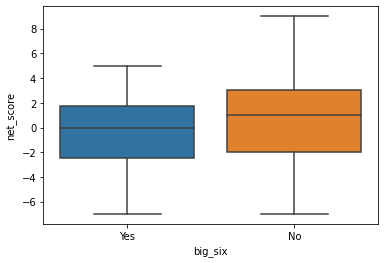

In [13]:
ax = sns.boxplot(x="big_six", y="net_score", data=df_net_score)

If you have two independent samples but you do not know that they have equal variance, you can use Welch's t-test.

Reference: https://stackoverflow.com/questions/13404468/t-test-in-pandas/13413842

In [14]:
# Welch's t-test for net score
ttest_ind(big_6_net_score['net_score'], non_big_6_net_score['net_score'], equal_var=False)

Ttest_indResult(statistic=-0.32816426633953927, pvalue=0.7495801858063824)

p-value returned from Welch's t-test = 0.749 (i.e. no statistically significant difference in net score between big six and non big six teams

##### Net Goal score

In [15]:
df_net_goal_score = pd.DataFrame(teamstats_df.groupby(['team_name', 'big_six'])['net_goal_score'].agg('sum')).reset_index(drop=False)
df_net_goal_score

,team_name,big_six,net_goal_score
0,Arsenal,Yes,1
1,Aston Villa,No,-3
2,Bournemouth,No,-3
3,Brighton & Hove Albion,No,6
4,Burnley,No,1
5,Chelsea,Yes,-2
6,Crystal Palace,No,2
7,Everton,No,2
8,Fulham,No,3
9,Leeds United,No,-1


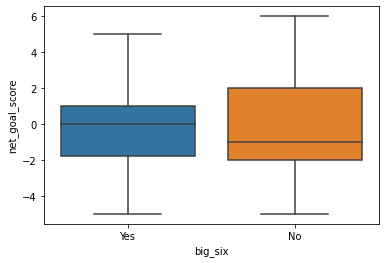

In [16]:
ax = sns.boxplot(x="big_six", y="net_goal_score", data=df_net_goal_score)

In [17]:
big_6_net_goal_score = df_net_goal_score[df_net_goal_score['big_six'] == 'Yes']
big_6_net_goal_score['net_goal_score'].describe()

count    6.000000
mean    -0.166667
std      3.371449
min     -5.000000
25%     -1.750000
50%      0.000000
75%      1.000000
max      5.000000
Name: net_goal_score, dtype: float64

In [18]:
non_big_6_net_goal_score = df_net_goal_score[df_net_goal_score['big_six'] == 'No']
non_big_6_net_goal_score['net_goal_score'].describe()

count    17.000000
mean      0.058824
std       3.210736
min      -5.000000
25%      -2.000000
50%      -1.000000
75%       2.000000
max       6.000000
Name: net_goal_score, dtype: float64

In [19]:
# Welch t-test for net goal score
from scipy.stats import ttest_ind
ttest_ind(big_6_net_goal_score['net_goal_score'], non_big_6_net_goal_score['net_goal_score'], equal_var=False)

Ttest_indResult(statistic=-0.14258840290127325, pvalue=0.8899596791319001)

##### Net Subjective score

In [21]:
df_net_subj_score = pd.DataFrame(teamstats_df.groupby(['team_name', 'big_six'])['net_subjective_score'].agg('sum')).reset_index(drop=False)
df_net_subj_score

,team_name,big_six,net_subjective_score
0,Arsenal,Yes,-4
1,Aston Villa,No,1
2,Bournemouth,No,-2
3,Brighton & Hove Albion,No,2
4,Burnley,No,5
5,Chelsea,Yes,2
6,Crystal Palace,No,4
7,Everton,No,3
8,Fulham,No,0
9,Leeds United,No,1


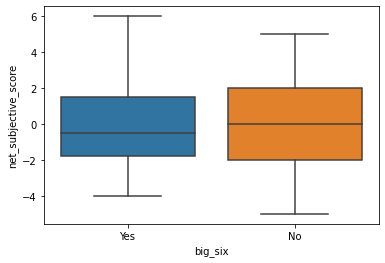

In [22]:
ax = sns.boxplot(x="big_six", y="net_subjective_score", data=df_net_subj_score)

In [21]:
big_6_net_subj_score = df_net_subj_score[df_net_subj_score['big_six'] == 'Yes']
big_6_net_subj_score['net_subjective_score'].describe()

count    6.000000
mean     0.166667
std      3.488075
min     -4.000000
25%     -1.750000
50%     -0.500000
75%      1.500000
max      6.000000
Name: net_subjective_score, dtype: float64

In [22]:
non_big_6_net_subj_score = df_net_subj_score[df_net_subj_score['big_six'] == 'No']
non_big_6_net_subj_score['net_subjective_score'].describe()

count    17.000000
mean      0.000000
std       2.783882
min      -5.000000
25%      -2.000000
50%       0.000000
75%       2.000000
max       5.000000
Name: net_subjective_score, dtype: float64

In [23]:
# Welch t-test for net subjective score
ttest_ind(big_6_net_subj_score['net_subjective_score'], non_big_6_net_subj_score['net_subjective_score'], equal_var=False)

Ttest_indResult(statistic=0.10575542788110588, pvalue=0.9185923175831191)

**Summary**  
p-values returned from Welch's t-test AND Student's t-test for all 3 scores (net score, net goal score, net subjective score) are all >0.05 (i.e. no statistically significant difference in net score between big six and non big six teams)

___
### (2) Which EPL teams were involved in most VAR overturn incidents, had the most FOR decisions, and the most AGAINST decisions?

##### Count of VAR incident overturn involvement

In [24]:
df_decisions_total = pd.DataFrame(teamstats_df.groupby(['team_name'])['overturns_total'].agg('sum')).reset_index(drop=False)
df_decisions_total.sort_values(by='overturns_total', ascending=False, inplace=True)
df_decisions_total.reset_index(drop=True, inplace=True)
df_decisions_total

,team_name,overturns_total
0,Tottenham Hotspur,30
1,Manchester United,29
2,West Ham United,28
3,Brighton & Hove Albion,28
4,Leicester City,28
5,Southampton,27
6,Liverpool,25
7,Manchester City,24
8,Chelsea,23
9,Crystal Palace,22


##### Count of VAR decision for

In [25]:
df_decisions_for = pd.DataFrame(teamstats_df.groupby(['team_name'])['decisions_for'].agg('sum')).reset_index(drop=False)
df_decisions_for.sort_values(by='decisions_for', ascending=False, inplace=True)
df_decisions_for.reset_index(drop=True, inplace=True)
df_decisions_for

,team_name,decisions_for
0,Brighton & Hove Albion,19
1,Manchester United,17
2,Tottenham Hotspur,15
3,Leicester City,15
4,Southampton,15
5,Crystal Palace,14
6,Manchester City,13
7,Liverpool,12
8,Burnley,12
9,Chelsea,12


##### Count of VAR decision against

In [26]:
df_decisions_against = pd.DataFrame(teamstats_df.groupby(['team_name'])['decisions_against'].agg('sum')).reset_index(drop=False)
df_decisions_against.sort_values(by='decisions_against', ascending=False, inplace=True)
df_decisions_against.reset_index(drop=True, inplace=True)
df_decisions_against

,team_name,decisions_against
0,Tottenham Hotspur,16
1,West Ham United,16
2,Liverpool,15
3,Arsenal,14
4,Wolverhampton Wanderers,13
5,Leicester City,13
6,Southampton,12
7,Sheffield United,12
8,Manchester United,12
9,Manchester City,11


##### Percentage For (based on total VAR overturn incidents)

In [27]:
df_decisions_for_percent = pd.DataFrame(teamstats_df.groupby(['team_name'])['decisions_for', 'overturns_total'].agg('sum')).reset_index(drop=False)
df_decisions_for_percent['decisions_for_percent'] = round((df_decisions_for_percent['decisions_for']/df_decisions_for_percent['overturns_total']) * 100, 1)
df_decisions_for_percent.sort_values(by='decisions_for_percent', inplace=True, ascending=False)
df_decisions_for_percent.reset_index(drop=True, inplace=True)
df_decisions_for_percent

<ipython-input-27-fd3e032489d6>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_decisions_for_percent = pd.DataFrame(teamstats_df.groupby(['team_name'])['decisions_for', 'overturns_total'].agg('sum')).reset_index(drop=False)


,team_name,decisions_for,overturns_total,decisions_for_percent
0,Brighton & Hove Albion,19,28,67.9
1,Burnley,12,18,66.7
2,Everton,9,14,64.3
3,Fulham,9,14,64.3
4,Crystal Palace,14,22,63.6
5,Manchester United,17,29,58.6
6,Newcastle United,7,12,58.3
7,Leeds United,5,9,55.6
8,Southampton,15,27,55.6
9,Manchester City,13,24,54.2


This leads to the next question, do these VAR decisions have a correlation with the team's league position and points tally?

___
### (3) Do VAR decisions correlate with EPL league positions and points tally?

In [28]:
epl_table_df = pd.read_csv(f'./data/EPL_Table_{file_date}.csv')
epl_table_df = rename_team_names(epl_table_df, 'team')
epl_table_df.columns = ['team_name', 'year', 'position', 'points']
epl_table_df.head()

,team_name,year,position,points
0,Liverpool,2019/2020,1,99
1,Manchester City,2019/2020,2,81
2,Manchester United,2019/2020,3,66
3,Chelsea,2019/2020,4,66
4,Leicester City,2019/2020,5,62


In [29]:
df_decisions_for_percent_yearly = pd.DataFrame(teamstats_df.groupby(['team_name', 'year'])['decisions_for', 'overturns_total'].agg('sum')).reset_index(drop=False)
df_decisions_for_percent_yearly['decisions_for_percent'] = round((df_decisions_for_percent_yearly['decisions_for']/df_decisions_for_percent_yearly['overturns_total']) * 100, 1)
df_decisions_for_percent_yearly.sort_values(by='team_name', inplace=True, ascending=True)
df_decisions_for_percent_yearly.reset_index(drop=True, inplace=True)
df_decisions_for_percent_yearly

<ipython-input-29-8aa426230cce>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_decisions_for_percent_yearly = pd.DataFrame(teamstats_df.groupby(['team_name', 'year'])['decisions_for', 'overturns_total'].agg('sum')).reset_index(drop=False)


,team_name,year,decisions_for,overturns_total,decisions_for_percent
0,Arsenal,2019/2020,4,9,44.4
1,Arsenal,2020/2021,3,12,25.0
2,Aston Villa,2019/2020,2,7,28.6
3,Aston Villa,2020/2021,7,11,63.6
4,Bournemouth,2019/2020,5,12,41.7
5,Brighton & Hove Albion,2019/2020,10,12,83.3
6,Brighton & Hove Albion,2020/2021,9,16,56.2
7,Burnley,2019/2020,7,11,63.6
8,Burnley,2020/2021,5,7,71.4
9,Chelsea,2020/2021,7,11,63.6


In [31]:
table_decision_for_df = pd.merge(epl_table_df, df_decisions_for_percent_yearly, how='left',
                       on=['team_name', 'year']).reset_index(drop=True)
table_decision_for_df

,team_name,year,position,points,decisions_for,overturns_total,decisions_for_percent
0,Liverpool,2019/2020,1,99,5,8,62.5
1,Manchester City,2019/2020,2,81,8,16,50.0
2,Manchester United,2019/2020,3,66,10,13,76.9
3,Chelsea,2019/2020,4,66,5,12,41.7
4,Leicester City,2019/2020,5,62,8,15,53.3
5,Tottenham Hotspur,2019/2020,6,59,8,15,53.3
6,Wolverhampton Wanderers,2019/2020,7,59,2,9,22.2
7,Arsenal,2019/2020,8,56,4,9,44.4
8,Sheffield United,2019/2020,9,54,3,11,27.3
9,Burnley,2019/2020,10,54,7,11,63.6


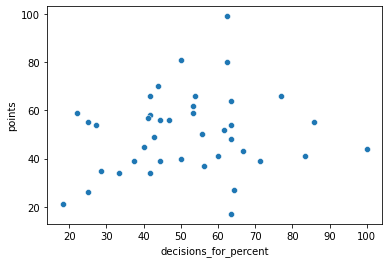

In [35]:
sns.scatterplot(data=table_decision_for_df, x="decisions_for_percent", y="points");

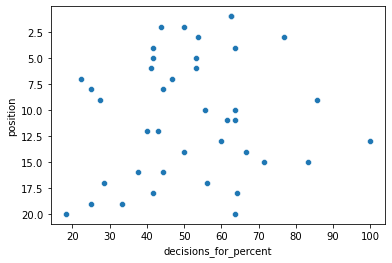

In [36]:
ax = sns.scatterplot(data=table_decision_for_df, x="decisions_for_percent", y="position");
ax.invert_yaxis()